In [1]:
# Ensure the necessary packages are installed
!pip install scikit-posthocs

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import io

from scipy.stats import wilcoxon, friedmanchisquare
import scikit_posthocs as sp

In [3]:
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[file_name]))
df

Saving text_classification_port.xlsx to text_classification_port.xlsx


,index,text,Token,Perplexity,Burstiness,AI Metric
0,724,introdução_humano_62.3.docx,598,73.292542,0.828193,0
1,678,introdução_humano_46.1.docx,884,71.769623,0.792928,0
2,789,introdução_humano_87.2.docx,693,52.951256,0.914968,0
3,100,conclusão_ia_101.docx,668,96.654350,0.232741,1
4,213,introdução_ia_65a.docx,625,86.598274,0.110107,1
...,...,...,...,...,...,...
884,666,introdução_humano_42.2.docx,825,72.740417,1.051292,0
885,165,introdução_ia_25a.docx,404,100.598648,0.170817,1
886,85,conclusão_ia_86.docx,614,81.104164,0.168786,1
887,55,conclusão_ia_56.docx,836,51.579498,0.413299,1


In [4]:
# Prepare X and y
X = df.drop(columns=['index', 'text', 'AI Metric'])
y = df['AI Metric']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Define classifiers
classifiers = {
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GaussianNB': GaussianNB()
}

# Train and evaluate models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'kappa']
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_proba_train = clf.predict_proba(X_train)[:, 1] if hasattr(clf, "predict_proba") else None
    y_pred_test = clf.predict(X_test)

    # Calculate metrics
    results[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train),
            'recall': recall_score(y_train, y_pred_train),
            'f1': f1_score(y_train, y_pred_train),
            'mcc': matthews_corrcoef(y_train, y_pred_train),
            'kappa': cohen_kappa_score(y_train, y_pred_train),
            'confusion_matrix': confusion_matrix(y_train, y_pred_train)
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test),
            'recall': recall_score(y_test, y_pred_test),
            'f1': f1_score(y_test, y_pred_test),
            'mcc': matthews_corrcoef(y_test, y_pred_test),
            'kappa': cohen_kappa_score(y_test, y_pred_test),
            'confusion_matrix': confusion_matrix(y_test, y_pred_test)
        }
    }

# Selecting the best model based on the average of metrics
train_scores = {name: [results[name]['train'][metric] for metric in metrics] for name in classifiers.keys()}
best_model = max(train_scores, key=lambda x: np.mean(train_scores[x]))

# Predict on the test set with the best model
best_clf = classifiers[best_model]
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf, "predict_proba") else None

# Display test metrics and confusion matrix
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test),
    'recall': recall_score(y_test, y_pred_test),
    'f1': f1_score(y_test, y_pred_test),
    'mcc': matthews_corrcoef(y_test, y_pred_test),
    'kappa': cohen_kappa_score(y_test, y_pred_test)
}

In [6]:
# Wilcoxon Rank Sum Test and Friedman Test
friedman_stat, friedman_p = friedmanchisquare(*train_scores.values())

# Restructure data for posthoc_conover
data = []
for classifier, scores in train_scores.items():
    for metric_idx, score in enumerate(scores):
        data.append([classifier, metrics[metric_idx], score])

df_scores_melted = pd.DataFrame(data, columns=['classifier', 'metric', 'score'])

# Pairwise Conover-Friedman Test
posthoc_conover = sp.posthoc_conover(df_scores_melted, val_col='score', group_col='classifier', p_adjust='holm')

# Create a DataFrame for Friedman test results
friedman_results = pd.DataFrame({'Friedman Statistic': [friedman_stat], 'p-value': [friedman_p]})
friedman_results = friedman_results.style.format({'Friedman Statistic': "{:.2f}", 'p-value': "{:.2f}"})

# Format Conover-Friedman test results
posthoc_conover = posthoc_conover.style.format("{:.2f}")

In [7]:
friedman_results

,Friedman Statistic,p-value
0,12.00,0.00


In [8]:
posthoc_conover

,ExtraTrees,GaussianNB,RandomForest
ExtraTrees,1.00,0.00,1.00
GaussianNB,0.00,1.00,0.00
RandomForest,1.00,0.00,1.00


In [9]:
# Assuming 'results' dictionary from your code (containing train metrics)
train_metrics = {model: results[model]['train'] for model in results}

# Create a pandas DataFrame
df_train_metrics = pd.DataFrame(train_metrics).T  # Transpose for better formatting
df_train_metrics.index.name = 'Model'  # Set index name to "Model"
print(f"Training results:")
print(f"Best Model: {best_model} based on training scores")
# Display the DataFrame
df_train_metrics

Training results:
Best Model: ExtraTrees based on training scores


,accuracy,precision,recall,f1,mcc,kappa,confusion_matrix
Model,,,,,,,
ExtraTrees,1.0,1.0,1.0,1.0,1.0,1.0,"[[361, 0], [0, 350]]"
RandomForest,1.0,1.0,1.0,1.0,1.0,1.0,"[[361, 0], [0, 350]]"
GaussianNB,0.994374,0.997126,0.991429,0.994269,0.98876,0.988745,"[[360, 1], [3, 347]]"


In [10]:
# Assuming 'results' dictionary from your code (containing train metrics)
test_metrics = {model: results[model]['test'] for model in results}

# Create a pandas DataFrame
df_test_metrics = pd.DataFrame(test_metrics).T  # Transpose for better formatting
df_test_metrics.index.name = 'Model'  # Set index name to "Model"
print(f"Testing results:")
# Display the DataFrame
df_test_metrics

Testing results:


,accuracy,precision,recall,f1,mcc,kappa,confusion_matrix
Model,,,,,,,
ExtraTrees,0.994382,0.988764,1.0,0.99435,0.988826,0.988764,"[[89, 1], [0, 88]]"
RandomForest,0.994382,0.988764,1.0,0.99435,0.988826,0.988764,"[[89, 1], [0, 88]]"
GaussianNB,0.994382,0.988764,1.0,0.99435,0.988826,0.988764,"[[89, 1], [0, 88]]"


In [12]:
# Show prediction and probability for each test sample
train_results = pd.DataFrame({"Prediction": y_pred_train, "Probability of being AI": y_proba_train})
# Format the 'p-value' column to display 2 decimal places
train_results['Probability of being AI'] = train_results['Probability of being AI'].apply(lambda x: '{:.2f}'.format(x))
print("Training Results:")
train_results

Training Results:


,Prediction,Probability of being AI
0,0,0.00
1,0,0.00
2,1,1.00
3,0,0.00
4,0,0.00
...,...,...
706,1,1.00
707,0,0.00
708,1,1.00
709,0,0.00


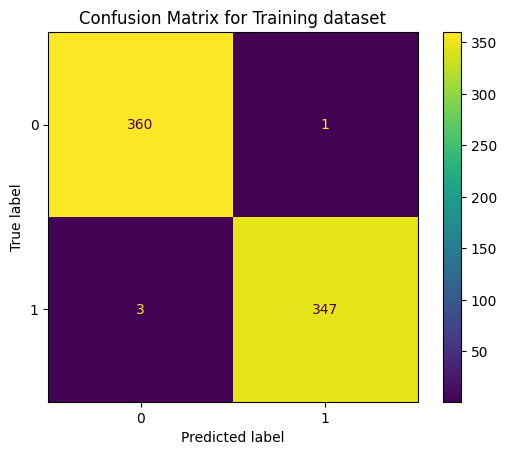

In [13]:
# Create the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for Training dataset")
plt.show()

In [14]:
# Show prediction and probability for each test sample
test_results = pd.DataFrame({"Prediction": y_pred_test, "Probability of being AI": y_proba_test})
print("Test Results:")
test_results

Test Results:


,Prediction,Probability of being AI
0,1,0.95
1,0,0.07
2,0,0.02
3,1,1.00
4,1,0.99
...,...,...
173,0,0.00
174,0,0.03
175,0,0.03
176,0,0.07


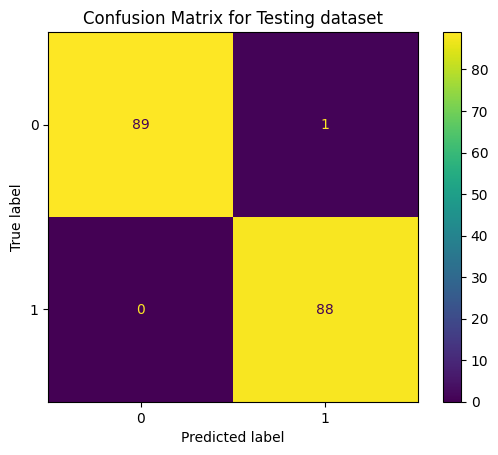

In [15]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for Testing dataset")
plt.show()

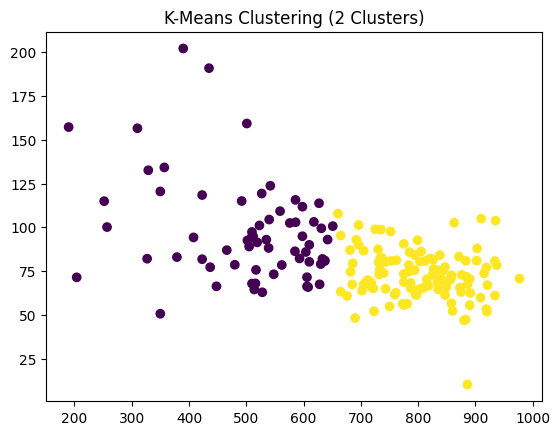

In [16]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_test)

# Access data using .iloc for numpy-style indexing
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=clusters, cmap='viridis')

plt.title("K-Means Clustering (2 Clusters)")
plt.show()

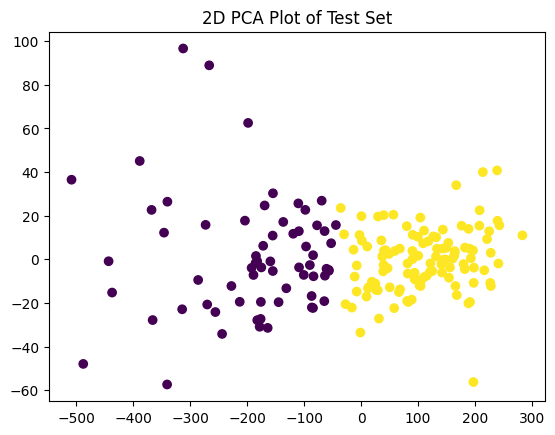

In [17]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=clusters, cmap='viridis')
plt.title("2D PCA Plot of Test Set")
plt.show()

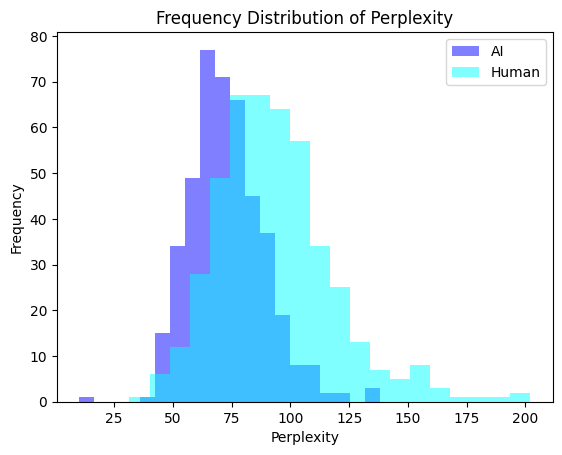

In [18]:
# Extract AI and human class labels
df_Human = df.loc[df['AI Metric'] == 0, 'Perplexity']
df_AI = df.loc[df['AI Metric'] == 1, 'Perplexity']

plt.hist(df_AI, bins=20, stacked=True, color=['blue'], alpha=0.5, label=['AI'])
plt.hist(df_Human, bins=20, stacked=True, color=['cyan'], alpha=0.5, label=['Human'])
plt.legend(loc='upper right')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Perplexity')
plt.show()

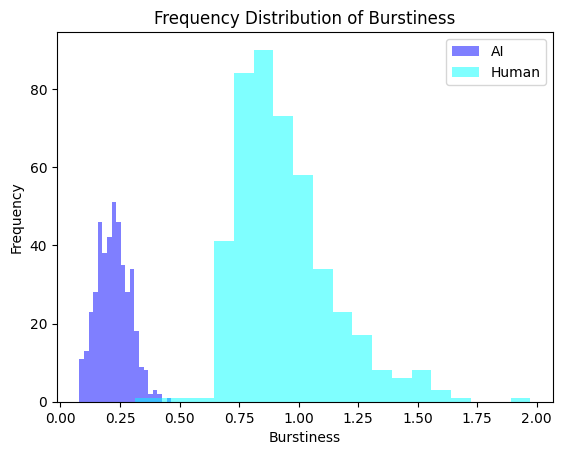

In [19]:
# Extract AI and human class labels
df_Human = df.loc[df['AI Metric'] == 0, 'Burstiness']
df_AI = df.loc[df['AI Metric'] == 1, 'Burstiness']

plt.hist(df_AI, bins=20, stacked=True, color=['blue'], alpha=0.5, label=['AI'])
plt.hist(df_Human, bins=20, stacked=True, color=['cyan'], alpha=0.5, label=['Human'])
plt.legend(loc='upper right')
plt.xlabel('Burstiness')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Burstiness')
plt.show()

In [20]:
# Install required libraries for classifying real texts
!pip install --upgrade docx2txt
!pip install transformers==4.23.0

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=a128509698783b1392773c65114f5a43a4b04c470c460edb8a8f63acb7330ceb
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [21]:
import docx2txt
import numpy as np
import torch
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [30]:
# Step 4: Upload the DOCX file of real texts to be check for plagiarism using AI
from google.colab import files
uploaded = files.upload()
filenames = uploaded.keys()
lista_texts = list(filenames)
lista_texts

Saving conclusão_humano_1.docx to conclusão_humano_1.docx
Saving conclusão_humano_2.docx to conclusão_humano_2.docx
Saving conclusão_humano_3.docx to conclusão_humano_3.docx
Saving conclusão_humano_4.docx to conclusão_humano_4.docx
Saving conclusão_humano_5.docx to conclusão_humano_5.docx
Saving conclusão_humano_6a.docx to conclusão_humano_6a.docx
Saving conclusão_humano_6b.docx to conclusão_humano_6b.docx
Saving conclusão_humano_7.docx to conclusão_humano_7.docx
Saving conclusão_humano_8.docx to conclusão_humano_8.docx
Saving conclusão_humano_9.docx to conclusão_humano_9.docx
Saving conclusão_humano_10.docx to conclusão_humano_10.docx


['conclusão_humano_1.docx',
 'conclusão_humano_2.docx',
 'conclusão_humano_3.docx',
 'conclusão_humano_4.docx',
 'conclusão_humano_5.docx',
 'conclusão_humano_6a.docx',
 'conclusão_humano_6b.docx',
 'conclusão_humano_7.docx',
 'conclusão_humano_8.docx',
 'conclusão_humano_9.docx',
 'conclusão_humano_10.docx']

In [31]:
# Step #1: Function to upload and read DOCX file
def upload_and_read_word(uploaded_file):
  text = docx2txt.process(uploaded_file)
  text = text.replace('\n', '')
  return text

# Step 2: Calculate Perplexity
def calculate_perplexity(text):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    tokens = tokenizer.encode(text, return_tensors='pt')
    max_length = 1024
    stride = 512
    lls = []

    for i in range(0, tokens.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, tokens.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = tokens[:, begin_loc:end_loc]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs[0] * trg_len

        lls.append(log_likelihood)

    perplexity = torch.exp(torch.stack(lls).sum() / end_loc)
    return perplexity.item()

# Step 3: Analyze Burstiness
def calculate_burstiness(text):
    sentences = text.split('.')
    sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence]

    mean_length = np.mean(sentence_lengths)
    std_dev = np.std(sentence_lengths)

    burstiness = std_dev / mean_length if mean_length else 0
    return burstiness

In [32]:
# Main execution
if __name__ == "__main__":
    lista_perplexity = []
    lista_burstiness = []
    lista_token_length = []
    for files in lista_texts:
        text = upload_and_read_word(files)
        perplexity = calculate_perplexity(text)
        lista_perplexity.append(perplexity)
        burstiness = calculate_burstiness(text)
        lista_burstiness.append(burstiness)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        token_length = len(tokenizer.encode(text))
        lista_token_length.append(token_length)


df_texts = pd.DataFrame({'text': lista_texts, 'Token': lista_token_length,
                         'Perplexity': lista_perplexity, 'Burstiness': lista_burstiness})
df_texts

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,text,Token,Perplexity,Burstiness
0,conclusão_humano_1.docx,794,52.118839,0.541733
1,conclusão_humano_2.docx,468,130.004425,0.954643
2,conclusão_humano_3.docx,388,143.195389,1.237567
3,conclusão_humano_4.docx,371,100.938171,1.142330
4,conclusão_humano_5.docx,271,103.201263,1.522167
5,conclusão_humano_6a.docx,696,97.457260,0.923772
6,conclusão_humano_6b.docx,376,113.768066,1.473744
7,conclusão_humano_7.docx,811,117.469994,0.707268
8,conclusão_humano_8.docx,799,92.631905,0.891354
9,conclusão_humano_9.docx,516,93.188660,0.986518


In [33]:
X_texts = df_texts.drop(columns=['text'])
scaler = StandardScaler()
X_texts = scaler.fit_transform(X_texts)
# Assuming df_texts contains your new data
X_texts = df_texts[['Token', 'Perplexity', 'Burstiness']]  # Select relevant columns
X_texts = pd.DataFrame(X_texts, columns=['Token', 'Perplexity', 'Burstiness'])  # Assign feature names
y_pred_texts = best_clf.predict(X_texts)
y_proba_texts = best_clf.predict_proba(X_texts)[:, 1] if hasattr(best_clf, "predict_proba") else None

# Show prediction and probability for each test sample
texts_results = pd.DataFrame({"Prediction": y_pred_texts, "Probability of being AI": y_proba_texts})
print("Prediction results:")
texts_results

Prediction results:


,Prediction,Probability of being AI
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0
